In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from itertools import repeat
from scipy.sparse import coo_matrix
import scipy
import scipy.signal
import seaborn as sns

plt.style.use('classic')
%matplotlib inline

sns.set()

In [3]:
tl=pd.read_csv('../../Rscripts/data/source data/90360AAAE_M64783_PR35_005.02.csv',skiprows=[1,2,3], low_memory=False, error_bad_lines=False)

In [4]:
iddqdf=tl[np.logical_and(tl['BIN']==1,tl['WAF']==16)]

In [5]:
iddqdf=iddqdf[['XPos','YPos','Iddq_Delta_Before[0]']]

In [6]:
iddqdf=iddqdf.dropna()

In [31]:
def nniddqkernel(df):
    row = np.array(df['XPos'])
    col = np.array(df['YPos'])
    data = np.array(df['Iddq_Delta_Before[0]'])
    spm = coo_matrix((data, (row, col))).toarray()
    
    #Kernel to calculate the average of the values surrounding the center die
    kernel = (1/12) * np.array([[0,0,1,0,0],[0,1,1,1,0],[1,1,0,1,1],[0,1,1,1,0],[0,0,1,0,0]])

    avarr = scipy.signal.convolve2d(spm, kernel, 'same')
    
    deltaarr = spm - avarr
    
    deltaarr = deltaarr / np.std(df['Iddq_Delta_Before[0]'])
    
    patdfx = np.transpose(np.nonzero(deltaarr))[:,0]
    patdfx[np.isnan(patdfx)] = 0
    patdfy = np.transpose(np.nonzero(deltaarr))[:,1]
    patdfy[np.isnan(patdfy)] = 0
    patest = np.ravel(deltaarr)
    patest = patest[np.nonzero(patest)]
    
    patdf = pd.DataFrame({'x' : pd.Series(patdfx),
                          'y' : pd.Series(patdfy),
                          'patest' : pd.Series(patest)})
    
    patdf = patdf.fillna(0)
    patdf['x'] = patdf['x'].astype('int32')
    patdf['y'] = patdf['y'].astype('int32')
    
    return(patdf)

In [32]:
k = nniddqkernel(iddqdf)

In [33]:
k.loc[np.logical_and(k['x']==59,k['y']==42),:]

,patest,x,y
3499,-1.168825,59,42


In [34]:
k.describe()

,patest,x,y
count,8415.000000,8415.000000,8415.000000
mean,0.000679,67.373262,45.240761
std,0.991562,31.489202,21.274716
min,-7.786335,4.000000,3.000000
25%,-0.418063,42.000000,28.000000
50%,-0.036862,67.000000,45.000000
75%,0.402591,93.000000,62.000000
max,56.694685,129.000000,86.000000


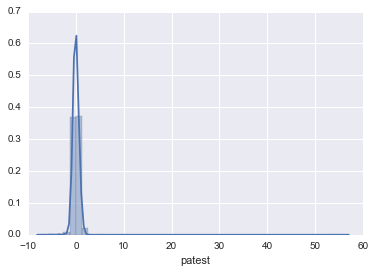

In [35]:
sns.distplot(k['patest'])

In [40]:
k.loc[k['patest']>(1.15),['patest']].size

305

In [41]:
k.loc[k['patest']<(-1.15),['patest']].size

220